In [83]:
import numpy as np
import scipy
from scipy.sparse import csc_matrix, bmat, load_npz, csr_matrix
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import implicit

## Load Data

In [84]:
s = load_npz("data/yt_s.npz")
a_train = load_npz("data/yt_a_train.npz")
a_test = load_npz("data/yt_a_test.npz")
a_val = load_npz("data/yt_a_val.npz")
n_groups = a_train.shape[1]
n_users = s.shape[0]

In [85]:
def prepare_train_data(alpha, s, a_train, a_val):
    c_train = bmat([[alpha*s, a_train], [a_train.transpose(), None]])
    c_val = bmat([[alpha*s, a_val], [a_val.transpose(), None]])
    #c_test = bmat([[alpha*s, a_test], [a_test.transpose(), None]])    
    return c_train.astype(np.float64), c_val.astype(np.float64)

## SVD

In [86]:
def svd_get_recs(i, model, train_labels, n_groups):
        u, sig, vt = model
        score = (u[i,:]@np.diag(sig)@vt)[-n_groups:]
        score = np.multiply(score, np.logical_not(train_labels))
        score_index = np.flip(np.argsort(score))
        return score_index

In [87]:
"vrati listu (za k = 1:n) precisiona i recalla na testu za jednog usera"
def evaluate_model_user(i, n, model, c_train, c_val, n_groups, model_type):
    "i = user za kojeg generiramo recommendatione"
    true_labels = c_val.getrow(i).toarray().flatten()[-n_groups:]
    train_labels = c_train.getrow(i).toarray().flatten()[-n_groups:]
    
    "tu se dodaju novi modeli"
    if model_type == "SVD":
        score_index = svd_get_recs(i, model, train_labels, n_groups)
    if model_type == "ALS":
        score_index = als_get_recs(i, n, model, c_train, n_groups)
        
    positives = np.sum(true_labels)
    negatives = n_groups - positives
    user_i_stats = []
    for predictions in range(1, n+1):
        recommendations = score_index[:predictions]
        true_positives = np.sum(true_labels[recommendations] == 1)
        true_negatives = negatives - (predictions - true_positives)
        precision = true_positives/predictions
        sensitivity = true_positives/positives if positives != 0 else 1
        specificity = true_negatives/negatives
        user_i_stats.append((precision, sensitivity, specificity))
    return user_i_stats

In [88]:
def evaluate_model(model, c_train, c_val, n_users, n_groups, model_type):
    stats = []
    for i in tqdm(range(n_users)):
            if np.sum(c_val.getrow(i).toarray().flatten()[-n_groups:]) != 0:
                stats.append(evaluate_model_user(i, 50, model, c_train, c_val, n_groups, model_type))
    "stats mi je lista duljine broj usera, svaki element je lista duljine n koja sadrzi tupleove oblika (pr, se, sp)"
    pr_se_sp = []
    "pr_se_sp ce biti lista tupleova duljine n, tuple je oblika (mean_pr, mean_se, mean_sp) gdje je prosjek uzet po userima"
    for n in zip(*stats):
        pr_se_sp.append((np.mean([i for i,j,k in n]), np.mean([j for i,j,k in n]), np.mean([k for i,j,k in n])))
    "pss ce biti numpy array dimenzija n x 3, svaki stupac odgovara jednom od (pr, se, sp)"
    pss = np.array(pr_se_sp)
    return pss[:,0], pss[:,1], pss[:,2]

In [89]:
def get_score(precision, sensitivity, specificity):
    x=[(1-spec) for spec in specificity]
    area = np.trapz(y=sensitivity, x=x)
    return abs(area)

In [90]:
def svd_model(alpha, svd_rank, s, a_train, a_val, n_users, n_groups):
    c_train, c_val = prepare_train_data(alpha, s, a_train, a_val)
    model = svds(c_train, k = svd_rank)
    precision, sensitivity, specificity = evaluate_model(model, c_train, c_val, n_users, n_groups, model_type = "SVD")
    score = get_score(precision, sensitivity, specificity)
    return {"alpha" : alpha, "svd_rank" : svd_rank, "score" : score, "precision" : precision, "sensitivity" : sensitivity, "specificity" : specificity}

In [91]:
def validate_svd_model(alphas, svd_ranks, s, a_train, a_val, n_users, n_groups):
    validation_scores = []
    for alpha in alphas:
        for svd_rank in svd_ranks:
            validation_scores.append(svd_model(alpha, svd_rank, s, a_train, a_val, n_users, n_groups))
    return validation_scores

In [92]:
alphas = [3]
svd_ranks = [10]

In [104]:
validation_scores_svd = validate_svd_model(alphas, svd_ranks, s, a_train, a_val, n_users, n_groups)

100%|██████████| 10000/10000 [01:44<00:00, 96.03it/s]


In [106]:
validation_scores_svd

[{'alpha': 3,
  'svd_rank': 10,
  'score': 0.0007483539025352523,
  'precision': array([0.07300647, 0.05697737, 0.0465158 , 0.04017376, 0.0359375 ,
         0.03248473, 0.0298068 , 0.02759631, 0.02614643, 0.02471713,
         0.02362118, 0.02269666, 0.02184184, 0.02112839, 0.02060884,
         0.02008688, 0.01956294, 0.01915709, 0.01866635, 0.01819774,
         0.01781866, 0.01739445, 0.01696613, 0.01656228, 0.01613685,
         0.01573379, 0.01543542, 0.01513912, 0.01478894, 0.01444415,
         0.01417373, 0.01395811, 0.01371882, 0.01350152, 0.0132851 ,
         0.01305451, 0.01281454, 0.01259074, 0.01239915, 0.01218346,
         0.01202429, 0.01182779, 0.01167489, 0.01149221, 0.01132962,
         0.01117996, 0.01103953, 0.0108853 , 0.01073463, 0.01059537]),
  'sensitivity': array([0.05152228, 0.07861634, 0.09376353, 0.10605379, 0.11644248,
         0.12387255, 0.13098653, 0.13796228, 0.14596257, 0.15279468,
         0.16037074, 0.1675306 , 0.1743104 , 0.17990907, 0.18626056,
       

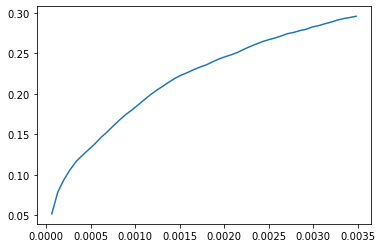

In [108]:
plt.plot(1 - validation_scores_svd[0]["specificity"], validation_scores_svd[0]["sensitivity"])

## EVALUACIJA GENERALNO

In [ ]:
"treba u evaluate_model_user za svaki model dodati granu u if-u u funkciji evaluate_model_user u kojoj se napravi score_index"
"score_index je lista/np.array koji sadrži indekse grupa sortirane po scoreu koji model daje, dakle sortirana lista grupa za recommendat"
"ideja je da se dotad sve sto ti treba za evaluirati model prenosi u varijabli model, a onda unutar tog ifa se pozove neka funkcija koja evaluira"
"za validaciju i kreiranje modela predlazem da se rade posebne funkcije za svaki jer nije bas zgodno napravit generalno, mogu biti po uzoru na ove"
precision, sensitivity, specificity = evaluate_model(model, c_train, c_val, n_users, n_groups, model_type = "SVD")
score = get_score(precision, sensitivity, specificity)
"dole primjer za als - 3 modificirane funkcije i onda se samo pozove - nije bas savrseno al mislim da ce bit skroz ok za nasih par modela"

## ALS

In [98]:
def als_get_recs(i, n, model, c_train, n_groups):
    recs = model.recommend(i, user_items = csr_matrix(c_train), N = n, filter_already_liked_items = True, filter_items = [j for j in range(c_train.shape[0]-n_groups)])
    indices = [rec[0]-n_users for rec in recs]
    scores = [rec[1] for rec in recs]
    score = np.zeros(n_groups)
    score[indices] = scores
    score_index = np.flip(np.argsort(score))
    return score_index

In [99]:
def als_model(alpha, svd_rank, s, a_train, a_val, n_users, n_groups):
    c_train, c_val = prepare_train_data(alpha, s, a_train, a_val)
    model = implicit.als.AlternatingLeastSquares(factors = n_factors, regularization = 2)
    model.fit(c_train)    
    precision, sensitivity, specificity = evaluate_model(model, c_train, c_val, n_users, n_groups, model_type = "ALS")
    score = get_score(precision, sensitivity, specificity)
    return {"alpha" : alpha, "n_factors" : n_factors, "score" : score, "precision" : precision, "sensitivity" : sensitivity, "specificity" : specificity}

In [100]:
def validate_als_model(alphas, svd_ranks, s, a_train, a_val, n_users, n_groups):
    validation_scores = []
    for alpha in alphas:
        for nf in n_factors:
            validation_scores.append(als_model(alpha, nf, s, a_train, a_val, n_users, n_groups))
    return validation_scores

In [101]:
alphas = [3]
n_factors = [10]

In [110]:
validation_scores_als = validate_als_model(alphas, svd_ranks, s, a_train, a_val, n_users, n_groups)

  0%|          | 4/10000 [00:00<04:48, 34.69it/s]

100%|██████████| 10000/10000 [03:37<00:00, 46.03it/s]


In [111]:
validation_scores_als

[{'alpha': 3,
  'svd_rank': 10,
  'score': 0.0008078250454885732,
  'precision': array([0.08324353, 0.06472252, 0.05320582, 0.04620151, 0.04159483,
         0.03820941, 0.03571429, 0.0329674 , 0.03108537, 0.02926994,
         0.02785805, 0.02670393, 0.02558231, 0.02465941, 0.02369792,
         0.02291554, 0.02209052, 0.02143199, 0.02087114, 0.02027209,
         0.01964671, 0.01910879, 0.0186645 , 0.0182011 , 0.01776401,
         0.01737608, 0.01706677, 0.01668334, 0.01630778, 0.01598869,
         0.01563804, 0.01537665, 0.01509029, 0.01475342, 0.01451278,
         0.01423686, 0.01396858, 0.01376758, 0.01351818, 0.01328125,
         0.01305916, 0.01287651, 0.01273369, 0.01253306, 0.01232938,
         0.01216384, 0.01198528, 0.01181697, 0.01165003, 0.01148168]),
  'sensitivity': array([0.05648463, 0.08689997, 0.10363966, 0.11713869, 0.13110482,
         0.14244687, 0.15256854, 0.1599654 , 0.16790475, 0.17493706,
         0.18283723, 0.19021723, 0.19621157, 0.20290172, 0.20734901,
       

In [112]:
plt.plot(1 - validation_scores_als[0]["specificity"], validation_scores-als[0]["sensitivity"])

NameError: name 'als' is not defined

## Katz

In [ ]:
def katz(t, beta, k):
    katz = beta*t
    a = beta*t
    for i in range(k-1):
        a = beta*a@t
        katz = katz + a
    return katz

In [ ]:
def katz_2(t, beta, k):
    t = t.astype(np.float64)
    u, s, vt = svds(t, k=3)
    s = np.diag(s)
    
    vtu = vt@u
    svtu = s@vtu
    
    katz = beta*s
    #a = beta*svtu
    small_matrix = beta * s @ vtu
    for i in range(k-1):
        small_matrix = beta * small_matrix @ s
        katz = katz + small_matrix
        small_matrix = small_matrix @ vtu
    katz = u @ katz @ vt
    return katz